<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">ADIM 1 : VERİ SETİNİ İÇERİ ALALIM</p>

In [81]:
# gerekli olan kütüphaneleri içeri alalım

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [82]:
pd.set_option('display.max_columns',None)

In [83]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [84]:
# Datayı içeri alalım
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
heart_disease.metadata

# variable information 
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [85]:
# 'y' DataFrame'indeki farklı değerlerinin sayısını bulalım
num_unique_values = y.nunique()

# 'y' sütunundaki farklı değerlerin miktarını bulalım
value_counts = y['num'].value_counts()

# Sonuçları görelim
print(num_unique_values)
print(value_counts)


num    5
dtype: int64
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [86]:
#EDA yapabilmek için datayı birleştirelim

# 'y' DataFrame'ini Series formatına dönüştürürelim
y = y.squeeze()

# y Series'inin adını 'target' olarak değiştirelim
y.name = 'target'

# X ve y'yi birleştirelim
df = pd.concat([X, y], axis=1)

# Sonuçları görelim
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [87]:
#Daha iyi tanımlamak için, kolon isimlerini düzenleyelim.

df = df.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'thalassemia'}, 
    errors="raise")

# Sonuçları görelim
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


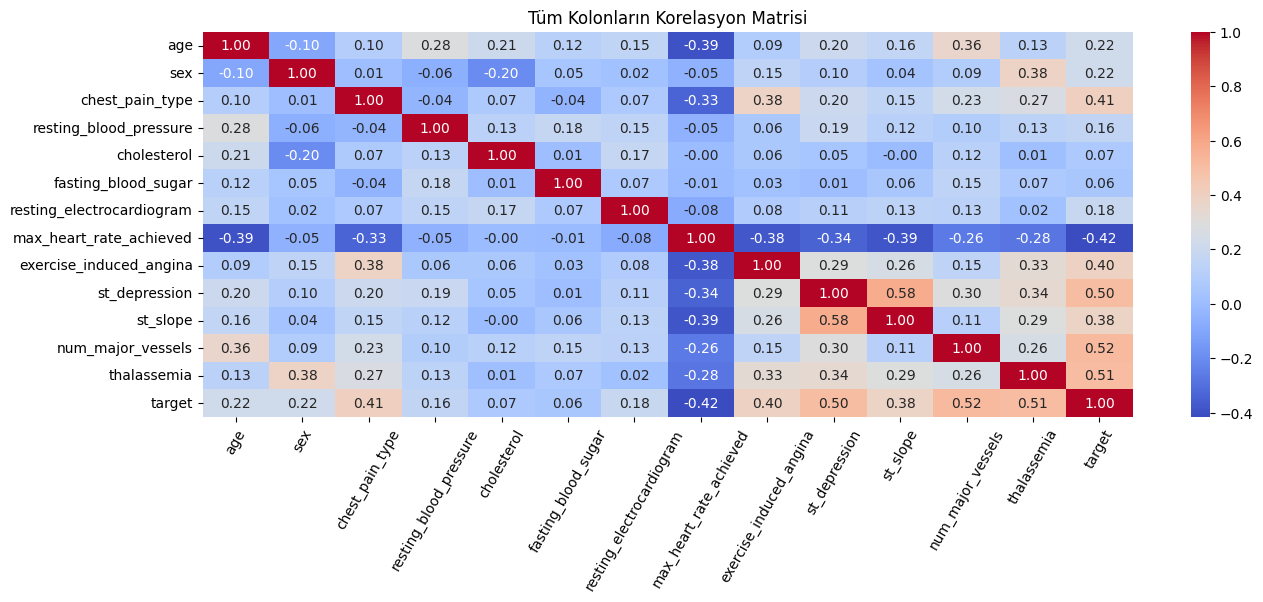

In [88]:
# Kolestrol konusunda datada bir terslik sezdiğim için tüm kolonlar arasındaki korelasyon matrisine bakmak istedim.

numerical_columns = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_columns.corr()

# Korelasyon matrisini görselleştirelim
plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Tüm Kolonların Korelasyon Matrisi')
plt.xticks(rotation=60)
plt.show()

In [89]:
# Her sütunda kaç farklı değer olduğunu hesaplayalım
unique_values = df.nunique()

# Sonuçları bir DataFrame olarak düzenleyelim
unique_values_df = pd.DataFrame(unique_values, columns=['farkli_deger_sayisi'])
unique_values_df.reset_index(inplace=True)
unique_values_df.columns = ['sutun', 'farkli_deger_sayisi']
print(unique_values_df)

                        sutun  farkli_deger_sayisi
0                         age                   41
1                         sex                    2
2             chest_pain_type                    4
3      resting_blood_pressure                   50
4                 cholesterol                  152
5         fasting_blood_sugar                    2
6   resting_electrocardiogram                    3
7     max_heart_rate_achieved                   91
8     exercise_induced_angina                    2
9               st_depression                   40
10                   st_slope                    3
11          num_major_vessels                    4
12                thalassemia                    3
13                     target                    5


In [90]:
#Veri setini tanıyalım

print(f"Veri Seti {df.shape[0]} Satır ve {df.shape[1]} Sutündan Oluşmaktadır.")
print(f"Veri Seti {df.ndim} Boyutludur.")
print(f"Veri Setinde Toplamda  {df.size} Veri(Hücre) Bulunmaktadır.")

Veri Seti 303 Satır ve 14 Sutündan Oluşmaktadır.
Veri Seti 2 Boyutludur.
Veri Setinde Toplamda  4242 Veri(Hücre) Bulunmaktadır.


In [91]:
#Tip özelliklerini ayrı ayrı yazdıralım

print("Object Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes == "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes == "object"].index))
print("\n")
print("Int veya Float Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes != "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes != "object"].index))

Object Tipindeki Öznitelikler: []
Sayısı: 0


Int veya Float Tipindeki Öznitelikler: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'resting_electrocardiogram', 'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
Sayısı: 14


<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 2: TİP DÖNÜŞÜMLERİNİ YAPALIM</p>

In [92]:
# Bu alanda bazı gizli Object tipindeki veriler var. Örneğin Cinsiyet. Bu verileri düzenleyelim. 
# Bu verilerin ne anlam içerdiğini çeşitli araştırmalardan ve baştaki açıklama kısmından öğrendim.


df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 1] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 4] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['resting_electrocardiogram'][df['resting_electrocardiogram'] == 0] = 'normal'
df['resting_electrocardiogram'][df['resting_electrocardiogram'] == 1] = 'ST-T wave abnormality'
df['resting_electrocardiogram'][df['resting_electrocardiogram'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 1] = 'upsloping'
df['st_slope'][df['st_slope'] == 2] = 'flat'
df['st_slope'][df['st_slope'] == 3] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 3] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 6] = 'normal'
df['thalassemia'][df['thalassemia'] == 7] = 'reversable defect'

# Sonuçları görelim
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,typical angina,145,233,greater than 120mg/ml,left ventricular hypertrophy,150,no,2.3,downsloping,0.0,normal,0
1,67,male,asymptomatic,160,286,lower than 120mg/ml,left ventricular hypertrophy,108,yes,1.5,flat,3.0,fixed defect,2
2,67,male,asymptomatic,120,229,lower than 120mg/ml,left ventricular hypertrophy,129,yes,2.6,flat,2.0,reversable defect,1
3,37,male,non-anginal pain,130,250,lower than 120mg/ml,normal,187,no,3.5,downsloping,0.0,fixed defect,0
4,41,female,atypical angina,130,204,lower than 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,fixed defect,0


In [93]:
#Tip özelliklerini ayrı ayrı yazdıralım

print("Object Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes == "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes == "object"].index))
print("\n")
print("Int veya Float Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes != "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes != "object"].index))

Object Tipindeki Öznitelikler: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_electrocardiogram', 'exercise_induced_angina', 'st_slope', 'thalassemia']
Sayısı: 7


Int veya Float Tipindeki Öznitelikler: ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'target']
Sayısı: 7


In [94]:
# Daha sonra kullanmak için verileri gruplandıralım 

# numerical (fearures 6)
num_feats = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']

# categorical (binary)
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']

# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'thalassemia']
cat_feats = nom_feats + bin_feats

<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 3: KORELASYON İNCELEYELİM</p>


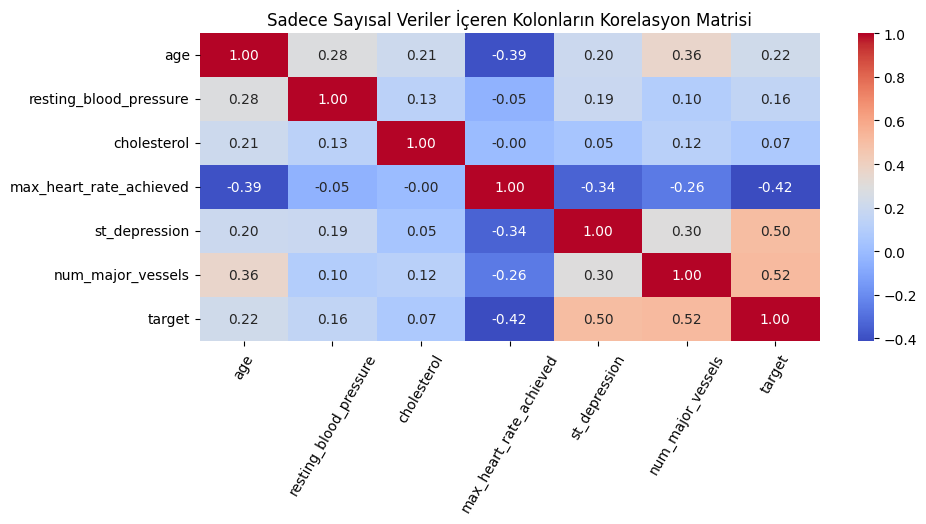

In [95]:
# Korelasyon için datada anlamlı olan veriler içeren sütunları seçelim
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Korelasyon matrisini oluşturalım
corr_matrix = numerical_columns.corr()

# Korelasyon matrisini görselleştirelim
plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Sadece Sayısal Veriler İçeren Kolonların Korelasyon Matrisi')
plt.xticks(rotation=60)
plt.show()

In [96]:
# Korelasyonun yüksek olduğu kolonları otomatik hesaplamak için bir yöntem geliştirelim;

# Korelasyon matrisini yeninden hesaplayalım,
correlation_matrix = numerical_columns.corr()

# Korelasyon katsayısı 0,75'ten büyük veya eşit olan özellikleri tanımlamak için bir alan oluşturualım,
high_correlation_mask = correlation_matrix >= 0.75

# Yüksek derecede ilişkili özellikleri tanımlayıp listeleyelim,
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Yüksek derecede ilişkili özellikleri yazdıralım.
print("Yüksek Korelasyonlu Stunlar:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} ve {feature2}")

Yüksek Korelasyonlu Stunlar:


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Grafiğe Dair Yorumlar:</span></b> </div>
Özellikler arasındaki korelasyon en iyi ihtimalle zayıf olarak çıkmaktadır.

Sayısal özelliklerden num_major_vessels, max_heart_rate_achieved ve st_depression hedef değişkenle sırasıyla; 0,52, -0,42, 0,50 olarak korelasyon katsayısıyla bir miktar eşlenik görünse de düşük olarak nitelendirilir

Tip dönüşümününden önce hesaplanan kategorik özelliklerden chest_pain_type, num_major_vessels, talasemi ve exercise_induced_angina hedef değişkenle daha iyi ilişkiliydi; num_major_vessels 0,52 ile en yüksek olanıdır.

Kolesterol (benim için yukarıda tekrar kolerasyona bakmama sebep olsa da) kalp hastalığıyla ilişkili değildir.

Özet: daha yüksek tahmin gücüne sahip özellikler, chest_pain_type, num_major_vessels, talasemi, exercise_induced_angina max_heart_rate_achieved ve st_depression olabilir.

<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 4: EKSİK VE GİZLİ EKSİK VERİLERİ İNCELEYELİM</p>

In [97]:
# Her sütundaki eksik değer sayısını ve oranını hesaplayalım
missing_data = df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
age,0,0.00
sex,0,0.00
chest_pain_type,0,0.00
resting_blood_pressure,0,0.00
cholesterol,0,0.00
fasting_blood_sugar,0,0.00
resting_electrocardiogram,0,0.00
max_heart_rate_achieved,0,0.00
exercise_induced_angina,0,0.00
st_depression,0,0.00


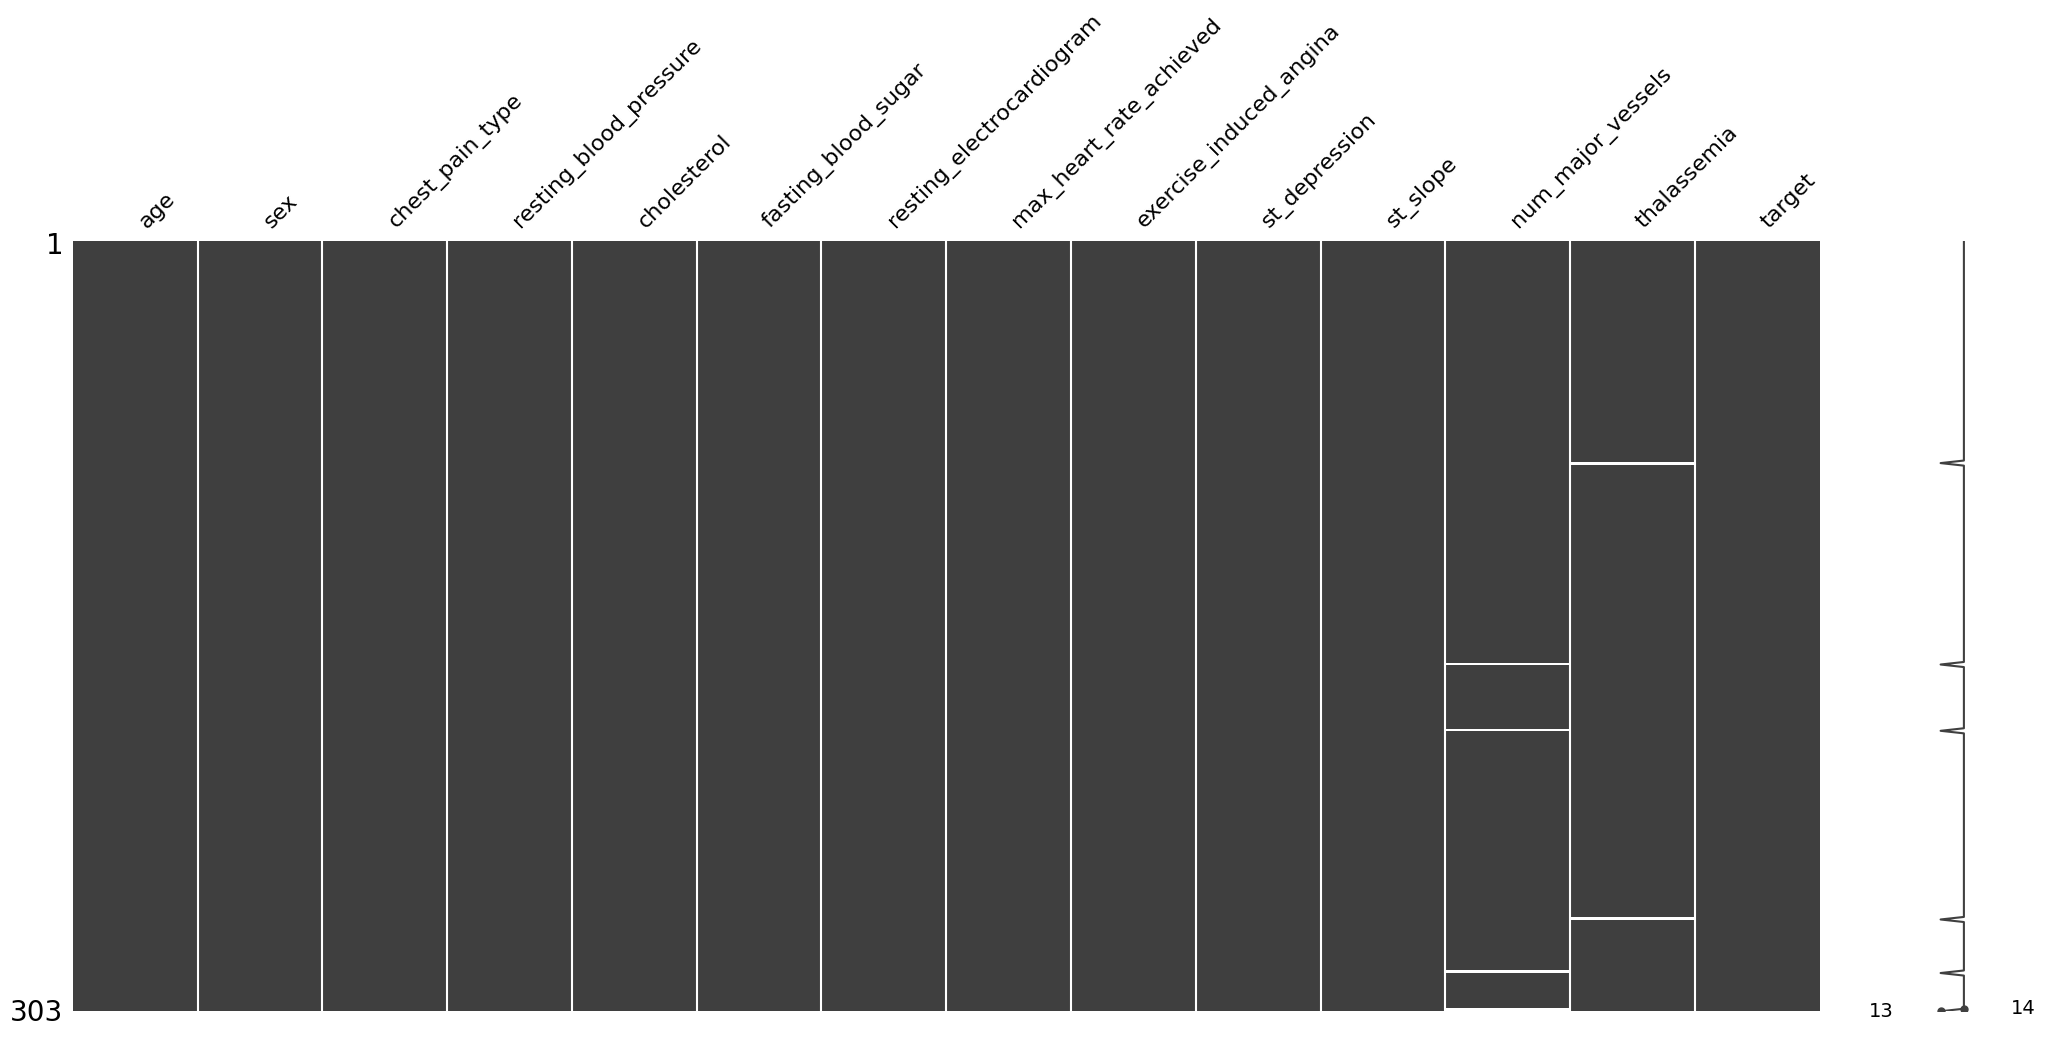

In [98]:
# Veri setindeki eksik değerleri görselleştirmek için missing no kütüphanesinden yararlanalım.
df = pd.DataFrame(df)

# Veri setindeki eksik değerleri görselleştirelim.
msno.matrix(df)
plt.show()

In [99]:
#Tekrar eden verileri inceleyelim.
print("Terkar eden veriler: ",df.duplicated().sum())

Terkar eden veriler:  0


In [100]:
# Boş hücre ve 0 değerlerini kontrol edelim
def check_zeros_and_nulls(df):
    columns_with_zeros = []
    columns_with_nulls = []
    
    for column in df.columns:
        if (df[column] == 0).any():
            columns_with_zeros.append(column)
        if df[column].isnull().any():
            columns_with_nulls.append(column)
    
    return columns_with_zeros, columns_with_nulls

columns_with_zeros, columns_with_nulls = check_zeros_and_nulls(df)

print(f"0 değeri içeren sütunlar: {columns_with_zeros}")
print(f"Boş/NaN değer içeren sütunlar: {columns_with_nulls}")

0 değeri içeren sütunlar: ['st_depression', 'num_major_vessels', 'target']
Boş/NaN değer içeren sütunlar: ['num_major_vessels', 'thalassemia']


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>YORUMLAR</span></b> </div>

Eksik verilerin datadan çıkarılmasında sakınca olmadığını düşünüyorum.

İçinde Sıfır içeren hücrelerin de olması gerektiği gibi kalmasını planlıyorum.

Set içinde tekrar eden veri olmadığı da gözlenmiştir.

<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 5: EKSİK-YANLIŞ VERİLERİ DÜZENLEYELİM </p>

In [101]:
# NaN içeren satırları filtreleyelim
nan_rows = df[df.isna().any(axis=1)]


# Boş değer içeren satırları yazdıralım
nan_rows

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
87,53,female,non-anginal pain,128,216,lower than 120mg/ml,left ventricular hypertrophy,115,no,0.0,upsloping,0.0,NaN,0
166,52,male,non-anginal pain,138,223,lower than 120mg/ml,normal,169,no,0.0,upsloping,NaN,fixed defect,0
192,43,male,asymptomatic,132,247,greater than 120mg/ml,left ventricular hypertrophy,143,yes,0.1,flat,NaN,reversable defect,1
266,52,male,asymptomatic,128,204,greater than 120mg/ml,normal,156,yes,1.0,flat,0.0,NaN,2
287,58,male,atypical angina,125,220,lower than 120mg/ml,normal,144,no,0.4,flat,NaN,reversable defect,0
302,38,male,non-anginal pain,138,175,lower than 120mg/ml,normal,173,no,0.0,upsloping,NaN,fixed defect,0


In [102]:
# Boş (NaN) değer içeren satırları çıkartalım
df = df.dropna()

# Temizlenmiş veri çerçevesinin son satırlarını yazdıralım :) 
df.tail()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
297,57,female,asymptomatic,140,241,lower than 120mg/ml,normal,123,yes,0.2,flat,0.0,reversable defect,1
298,45,male,typical angina,110,264,lower than 120mg/ml,normal,132,no,1.2,flat,0.0,reversable defect,1
299,68,male,asymptomatic,144,193,greater than 120mg/ml,normal,141,no,3.4,flat,2.0,reversable defect,2
300,57,male,asymptomatic,130,131,lower than 120mg/ml,normal,115,yes,1.2,flat,1.0,reversable defect,3
301,57,female,atypical angina,130,236,lower than 120mg/ml,left ventricular hypertrophy,174,no,0.0,flat,1.0,fixed defect,1


<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 6: NİTELİK DAĞILIMLARINI GRAFİKLE İNCELEYELİM </p>

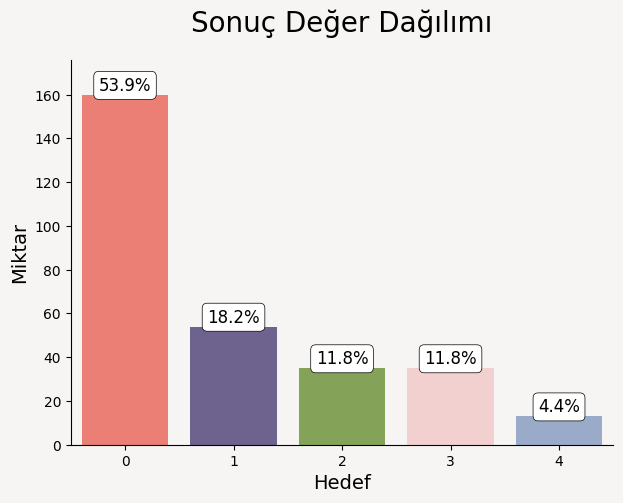

In [103]:
# Çubuk Grafiği için kodları yazalım 

# Renk paletini düzenleyelim
mypal = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#955251']

plt.figure(figsize=(7, 5), facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['target'], palette=mypal)

# Arka plan rengini ayarlayalım
ax.set_facecolor('#F6F5F4')

# Çubuklar üzerinde yüzdelik etiketleri gösterelim
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 2,  # Etiketin yüksekliğini biraz aşağı çekelim
        '{:.1f}%'.format((height / total) * 100),
        ha="center",
        fontsize=12,  # Yazı tipini biraz büyütelim
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', linewidth=0.5)
    )

# Başlık ve eksen etiketlerini ayarlayalım
ax.set_title('Sonuç Değer Dağılımı', fontsize=20, y=1.05)
ax.set_xlabel('Hedef', fontsize=14)
ax.set_ylabel('Miktar', fontsize=14)

# Grafikteki kenar çizgilerini kaldıralım
sns.despine(right=True, top=True)

# Y ekseni sınırlarını biraz genişletelim
ax.set_ylim(0, max([p.get_height() for p in ax.patches]) * 1.1)

# Grafiği görelim
plt.show()


In [104]:
# 'target' sütununda 0'dan farklı olan tüm değerleri 1 olarak ayarlayalım
df['target'] = df['target'].apply(lambda x: 1 if x != 0 else 0)
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,typical angina,145,233,greater than 120mg/ml,left ventricular hypertrophy,150,no,2.3,downsloping,0.0,normal,0
1,67,male,asymptomatic,160,286,lower than 120mg/ml,left ventricular hypertrophy,108,yes,1.5,flat,3.0,fixed defect,1
2,67,male,asymptomatic,120,229,lower than 120mg/ml,left ventricular hypertrophy,129,yes,2.6,flat,2.0,reversable defect,1
3,37,male,non-anginal pain,130,250,lower than 120mg/ml,normal,187,no,3.5,downsloping,0.0,fixed defect,0
4,41,female,atypical angina,130,204,lower than 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,fixed defect,0


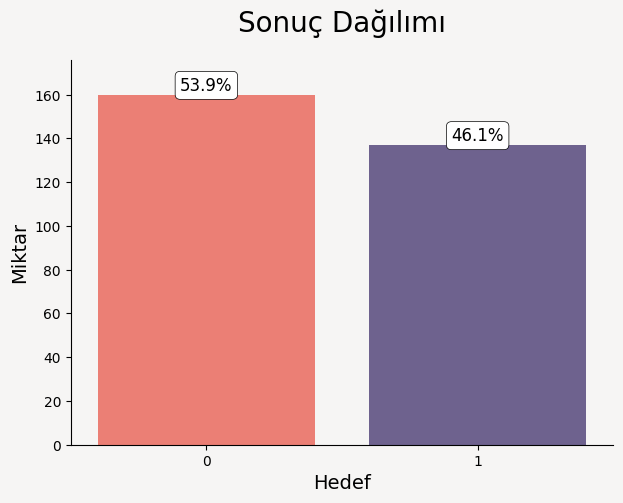

In [105]:
# Target'ı Binary Encoding (İkili Kodlama;label encoding) yaptıktan sonraki grafiği görelim.

plt.figure(figsize=(7, 5), facecolor='#F6F5F4')
ax = sns.countplot(x=df['target'], palette=mypal)
ax.set_facecolor('#F6F5F4')

total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 2, f'{percentage:.1f}%', 
            ha="center", fontsize=12,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', linewidth=0.5))

ax.set_title('Sonuç Dağılımı', fontsize=20, y=1.05)
ax.set_xlabel('Hedef', fontsize=14)
ax.set_ylabel('Miktar', fontsize=14)
sns.despine(right=True, top=True)
ax.set_ylim(0, max(p.get_height() for p in ax.patches) * 1.1)

# Grafiği görelim
plt.show()


In [106]:
# DataFrame'in temel özet istatistiklerini görelim.
df[num_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
max_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
st_depression,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
num_major_vessels,297.0,0.676768,0.938965,0.0,0.0,0.0,1.0,3.0


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>YORUMLAR</span></b> </div>

Target oranlarına göre; veri dağılımının dengeli olduğu görülmektedir.

Yaş; Veri setindeki ortalama yaş 54,5'tir. En yaşlısı 77 yaşında, en genci ise 29 yaşındadır.

Kolesterol: Ortalama kayıtlı kolesterol seviyesi 247'dir. Maksimum seviye 564 ve minimum seviye 126'dır. Araştırmalarıma göre; sağlıklı bir kolesterol seviyesi <200 mg / dl'dir ve genellikle yüksek kolesterol seviyesi kalp hastalığı ile ilişkilidir. Ancak korelasyon matrisinde buna dair bir bulguya raslanmamıştır. Veri setinin gerçek olmamasından kayankalanabilir.

Dinlenme kan basıncı: Ortalama 131, maksimum 200 ve 94 dk/atımdır.

Elde edilen maksimum kalp hızı: Kaydedilen ortalama maksimum kalp hızı 149,5 bpm'dir. Maksimum ve minimum sırasıyla 202 ve 71 bpm'dir.

St_depression (Kalp grafisinden okunan değer): Ortalama değeri 1,06'dır. Maksimum 6.2 ve minimum 0'dır.

Büyük kan damarı sayısı: Maksimum 3 ve minimum 0 büyük kan damarı gözlemlenmiştir. Ortalama değer 0.68'dir

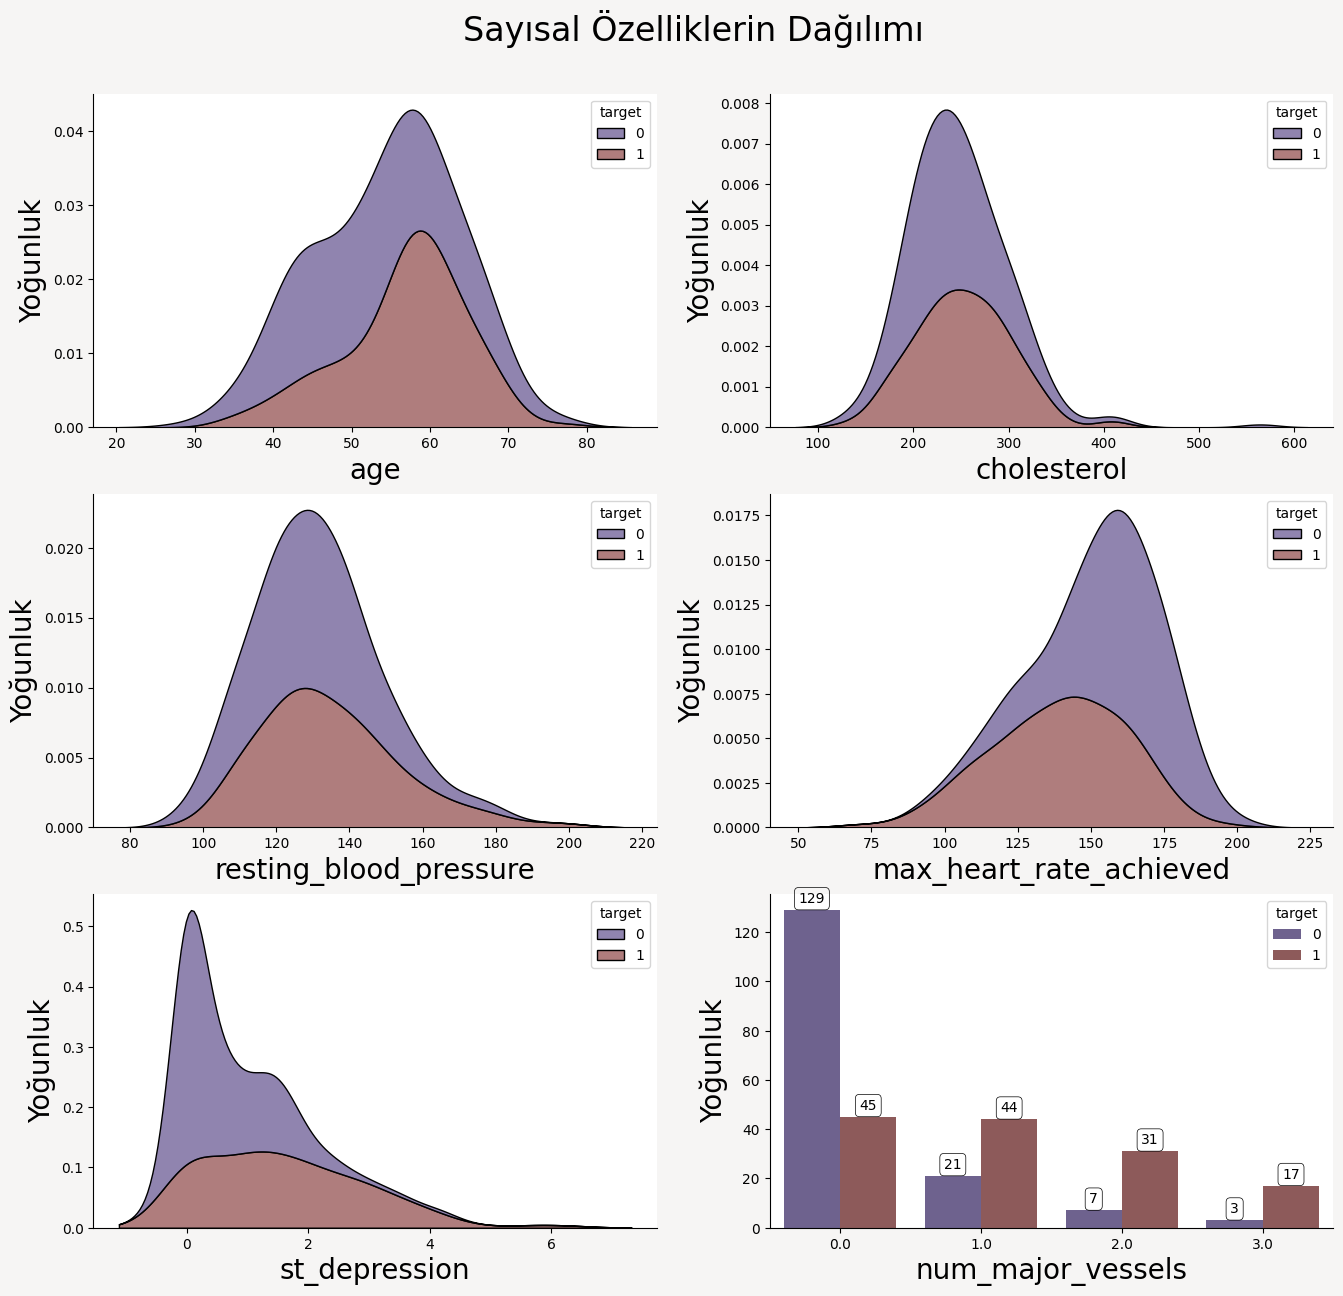

In [107]:
#Sayısal Özelliklerin Dağılımını inceleyelim

# Özelliklerin sayısını bulalım
L = len(num_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

# Grafik oluşturalım
fig, axes = plt.subplots(nrow, ncol, figsize=(16, 14), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92)  # Süper başlık için yer açma
axes = axes.flatten()

# Grafik çizimini yapalım
for i, col in enumerate(num_feats):
    ax = axes[i]  # İlgili subplot
    if col == 'num_major_vessels':
        sns.countplot(data=df, x=col, hue="target", palette=mypal[1::4], ax=ax)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.0f}'.format(height), ha="center",
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    else:
        sns.kdeplot(data=df, x=col, hue="target", multiple="stack", palette=mypal[1::4], ax=ax)
    
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("Yoğunluk", fontsize=20)
    sns.despine(ax=ax, right=True)
    sns.despine(ax=ax, offset=0, trim=False)

# Kalan boş subplot'ları kaldıralım
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Grafiği görelim
plt.suptitle('Sayısal Özelliklerin Dağılımı', fontsize=24)
plt.show()


<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 7: ÖZNİTELİK İLİŞKİLERİNİ İNCELEYELİM </p>

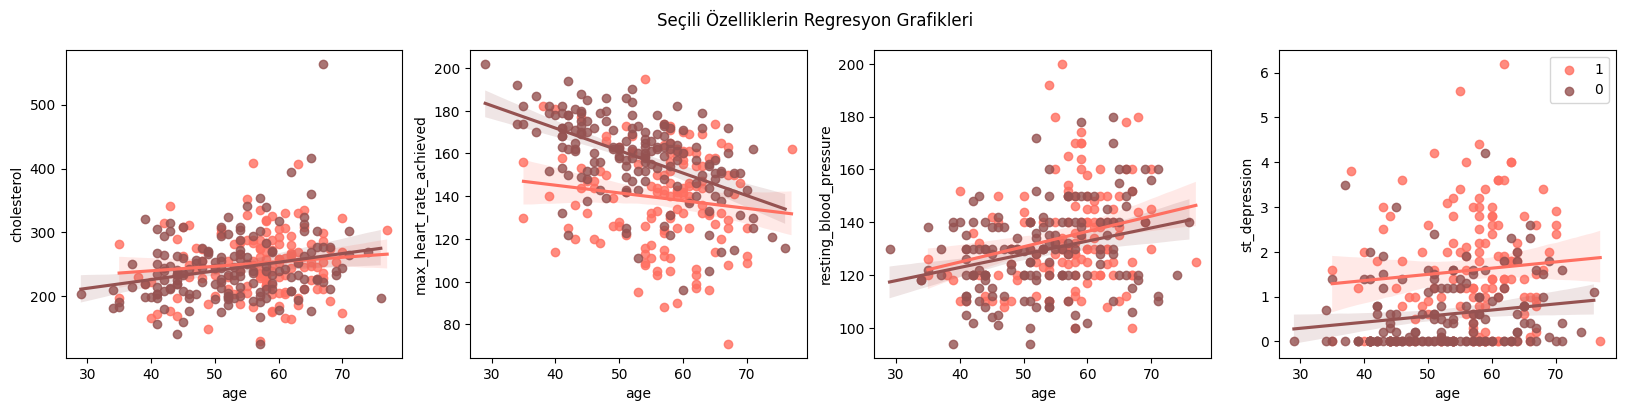

In [108]:
# 4 adet sayısal özelliğin Regresyon grafiklerini çizelim 
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.regplot(df[df['target'] ==1], x='age', y='cholesterol', ax = ax[0], color=mypal[0], label='1')
sns.regplot(df[df['target'] ==0], x='age', y='cholesterol', ax = ax[0], color=mypal[5], label='0')
sns.regplot(df[df['target'] ==1], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[0], label='1')
sns.regplot(df[df['target'] ==0], x='age', y='max_heart_rate_achieved', ax = ax[1], color=mypal[5], label='0')
sns.regplot(df[df['target'] ==1], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[0], label='1')
sns.regplot(df[df['target'] ==0], x='age', y='resting_blood_pressure', ax = ax[2], color=mypal[5], label='0')
sns.regplot(df[df['target'] ==1], x='age', y='st_depression', ax = ax[3], color=mypal[0], label='1')
sns.regplot(df[df['target'] ==0], x='age', y='st_depression', ax = ax[3], color=mypal[5], label='0')
plt.suptitle('Seçili Özelliklerin Regresyon Grafikleri')

# Grafiği görelim
plt.legend();

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>YORUMLAR</span></b> </div>

Birinci grafikte; yaş (age) ile kolesterol (cholesterol) arasındaki ilişkiyi gösteren bir dağılım grafiği yer alıyor. Noktaların genel dağılımı, yaş arttıkça kolesterol seviyesinin de artma eğiliminde olduğunu gösteriyor. Ancak, bu ilişki çok güçlü değil; yani, yaş ile kolesterol arasında belirgin bir doğrusal ilişki yok. Grafikteki düz çizgilerin ise eğimi pozitif, bu da yaş arttıkça kolesterol seviyesinin artma eğiliminde olduğunu gösteriyor.Çizginin etrafındaki gölgeli alan, tahminin güven aralığını gösteriyor. Bu alan, yaşın artmasıyla birlikte kolesterol seviyesinin değişkenliğini yansıtıyor. Sonuç olarak, Yaş ile kolesterol arasında pozitif bir ilişki gözlemleniyor, ancak bu ilişki oldukça dağınık ve kesin bir bağlantı kurulamıyor.

İkinci grafik, yaş ile maksimum kalp atış hızı arasında negatif bir ilişki olduğu ve bu ilişkinin belirli bir değişkenlik gösterdiğini ortaya koymaktadır.

Üçüncü grafikte, yaş arttıkça dinlenme kan basıncının artma eğilimi olduğunu görülüyor. Bu, yaş ile dinlenme kan basıncı arasında pozitif bir ilişki olduğunu ortaya koyuyor. Grafik yaş ile dinlenme kan basıncı arasında pozitif bir ilişki olduğunu ve bu ilişkinin belirli bir değişkenlik gösterdiğini ortaya koyuyor.

Dördüncü grafikte ise, yaş ile st-depresyon düzeyi arasındaki ilişkiyi gösteren bir dağılım grafiği bulunmaktadır. Genel olarak, yaş arttıkça st-depresyon düzeyinin de arttığına dair bir eğilim gözlemleniyor. Ancak bu ilişki çok belirgin değil.Özellikle bazı yaş gruplarında st-depresyon düzeyleri oldukça değişken. Her iki grup için çizilen regresyon çizgileri, yaş ile depresyon düzeyi arasındaki ilişkiyi gösteriyor. Özellikle 40-60 yaş aralığında daha fazla veri noktası bulunuyor. Buda bu yaş grubundaki bireylerin st-depresyon düzeylerinin daha fazla incelendiğini gösterebilir. Genel olarak, yaş ile st-depresyon düzeyi arasında pozitif bir ilişki olduğu görülüyor, ancak bu ilişki her yaş grubunda aynı şekilde değil. İlişkiyi anlamak için daha çok veriye ihtiyaç duyulabilir.

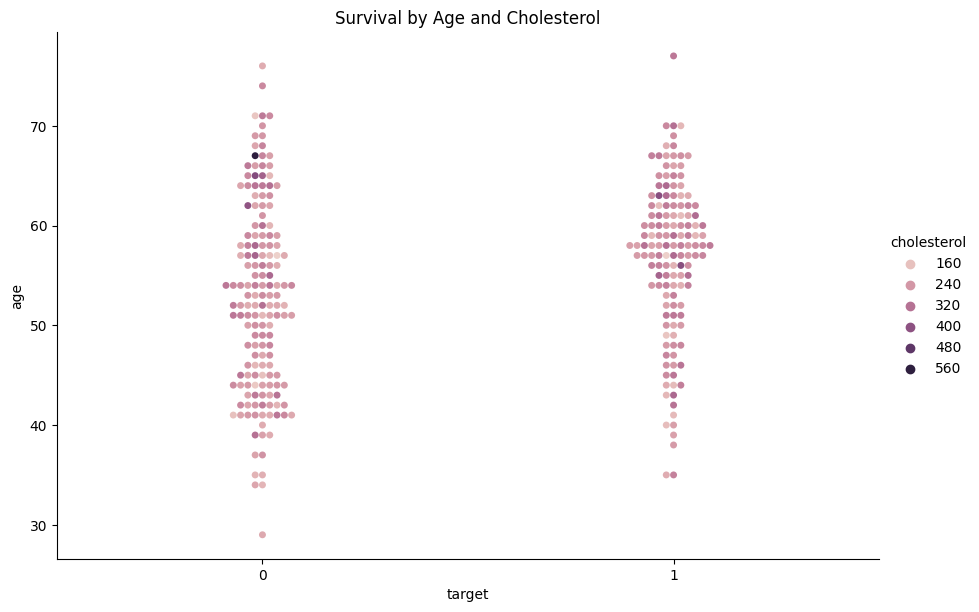

In [109]:
# Kategorik kolonları görselleştirmek için catplot kullanalım.
sns.catplot(x="target", y="age", hue="cholesterol", kind="swarm", data=df, height=6, aspect=1.5)
plt.title('Survival by Age and Cholesterol')

# Grafiği görelim
plt.show()

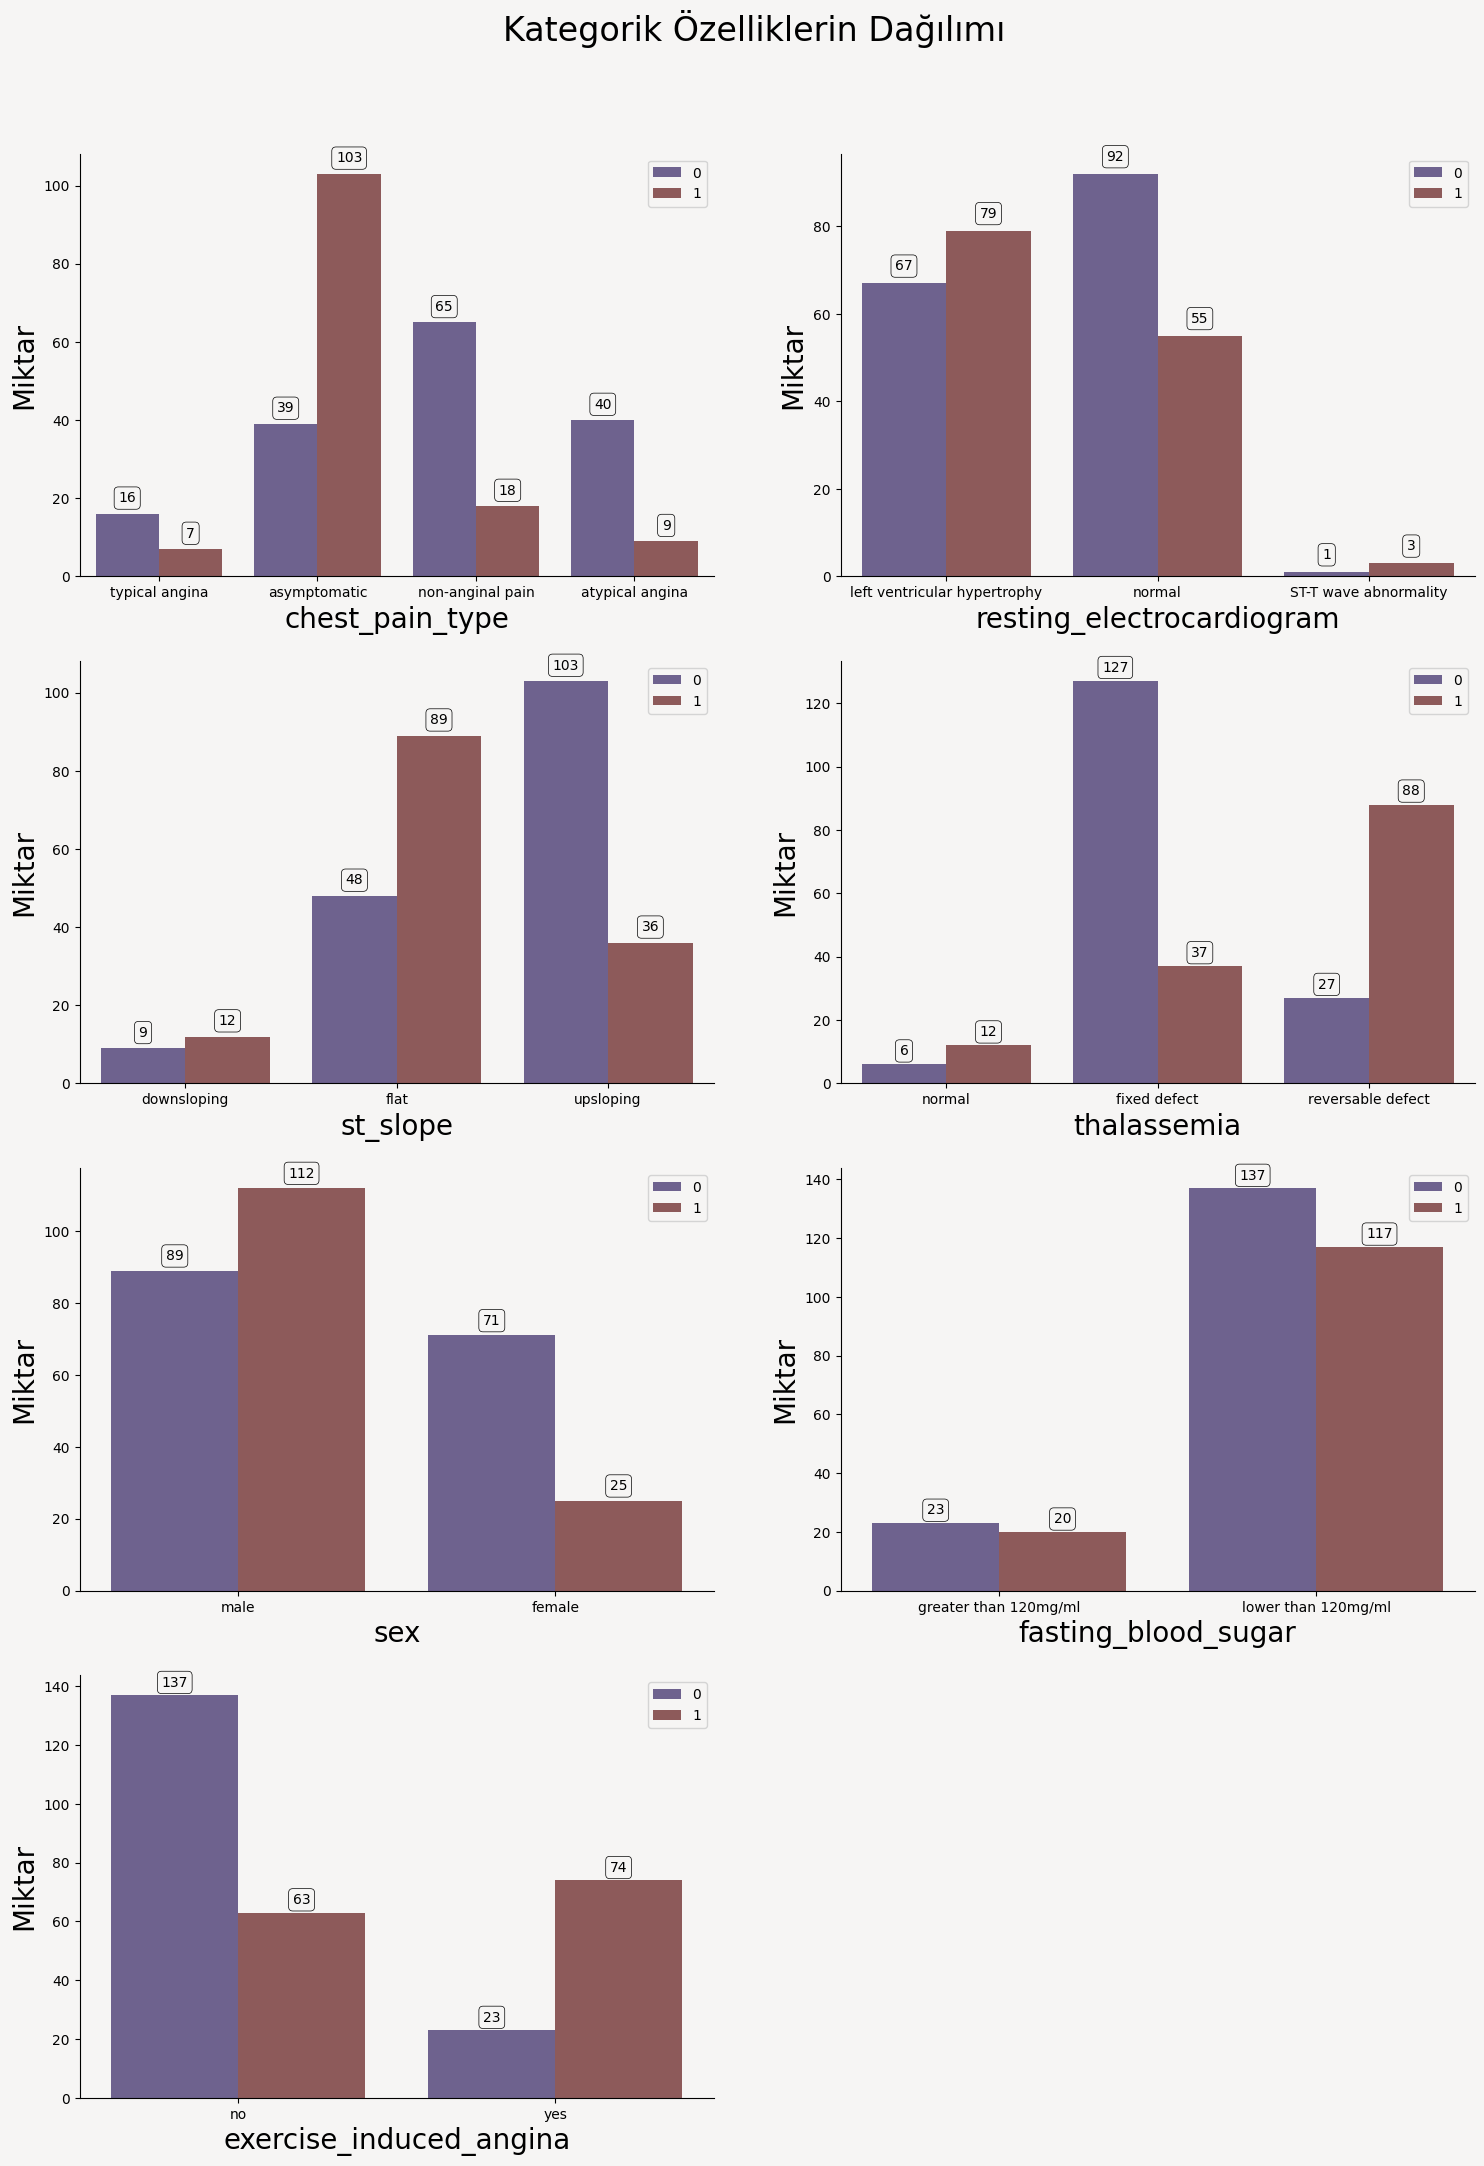

In [110]:
#Sayısal Özelliklerin Dağılımını inceleyelim

# Özelliklerin sayısını bulalım
def count_plot(df, cat_feats):    
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4')    
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        ax = sns.countplot(df, x=col, hue="target", palette=mypal[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("Miktar", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False) 
        plt.legend(facecolor='#F6F5F4')
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
        
        i = i +1

    plt.suptitle('Kategorik Özelliklerin Dağılımı' ,fontsize = 24)
    return 0

# Grafiği görelim
count_plot(df, cat_feats[0:-1]);

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Grafiklere Dair Yorumlar:</span></b> </div>

Veride eksik değer yok

Özellikler (sütunlar) veri türü: Altı özellik sayısal, Geri kalan (yedi özellik) kategorik değişkenler

Hedef değişken oldukça dengeli, %54'ü sağlıklı, %46'sı hastalıklı.

Özelikle hastalık olma olasılığı olan gruplar; chest_pain_type'a göre; asymptomatic olanlar, thalassemia'ya göre reversable defect olanlar, sex'e göre male olanlar, exercise_induced_angina'ya göre yes sonucu çıkanlara dikkat edilmelidir.


<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 8: AYKIRI GÖZLEM ANALİZİ YAPALIM </p>


In [111]:
#Aykırı gözlem analizi yapalım
def determine_anomaly_borders(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

num_feat = df.dtypes[df.dtypes != "object"].index
feat_borders = dict()
for i in num_feat:
    feat_borders[i] = determine_anomaly_borders(df, i)

# feat_borders'ı yazdırarak kontrol edelim
feat_borders

{'age': (28.5, 80.5),
 'resting_blood_pressure': (90.0, 170.0),
 'cholesterol': (113.5, 373.5),
 'max_heart_rate_achieved': (83.5, 215.5),
 'st_depression': (-2.4000000000000004, 4.0),
 'num_major_vessels': (-1.5, 2.5),
 'target': (-1.5, 2.5)}

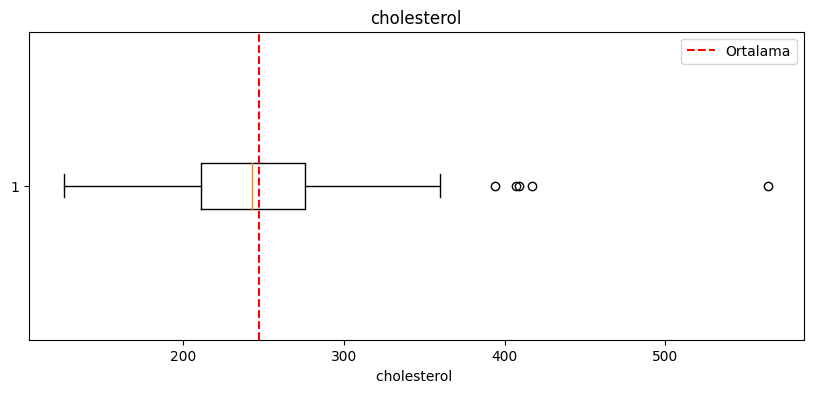

In [112]:
# Outlierları görmek ve boxplot çizmek için grafik boyutunu ayarlayalım. Kolestrol seviye özelliği dikkat çektiği için inceleyelim.
plt.figure(figsize=(10, 4))

# Box plot çizelim
plt.boxplot(df['cholesterol'], vert=False)

# Ortalamayı gösteren bir çizgi çizelim
plt.axvline(df['cholesterol'].mean(), color='red', linestyle='--', label='Ortalama')

# Eksen etiketlerini ve başlığı ayarlayalım
plt.xlabel('cholesterol ')
plt.title('cholesterol')

# Eksen etiketlerini ekleyelim
plt.legend()

# Grafiği görelim
plt.show()


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Anomaliye Dair Yorumlar:</span></b> </div>

Veriler kişillerin bireysel değerlerine dair olduğu için hiç bir değer anomali olarak değerlendirilmemiştir.

In [113]:
# Kendi yaş grubumdaki kadınların durumlarını merak ettim. :)

filtered_df = df[(df['age'] == 41) & (df['sex'] == 'female')]
filtered_df

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
4,41,female,atypical angina,130,204,lower than 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,fixed defect,0
50,41,female,atypical angina,105,198,lower than 120mg/ml,normal,168,no,0.0,upsloping,1.0,fixed defect,0
220,41,female,non-anginal pain,112,268,lower than 120mg/ml,left ventricular hypertrophy,172,yes,0.0,upsloping,0.0,fixed defect,0
241,41,female,atypical angina,126,306,lower than 120mg/ml,normal,163,no,0.0,upsloping,0.0,fixed defect,0


<a id="1"></a>
# <p style="padding:10px;background-color:black;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> ADIM 9. MAKİNE ÖĞRNEMESİ İÇİN MODEL KURALIM</p>

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>NOT:</span></b> </div>

Veri temizliğinden sonra yalnızca 297 vakamız var, bu tahmin yapmak için çok küçük bir veri miktarı. Bu nedenle, yapılan sonuçlara ihtiyatla yaklaşmamız gerektiğini gösteriyor.

In [114]:
#Tip özelliklerini ayrı ayrı yazdıralım
print("Object Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes == "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes == "object"].index))
print("\n")
print("Int veya Float Tipindeki Öznitelikler:", list(df.dtypes[df.dtypes != "object"].index))
print("Sayısı:", len(df.dtypes[df.dtypes != "object"].index))

Object Tipindeki Öznitelikler: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_electrocardiogram', 'exercise_induced_angina', 'st_slope', 'thalassemia']
Sayısı: 7


Int veya Float Tipindeki Öznitelikler: ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'target']
Sayısı: 7


In [115]:
# Kategorik sütunlar (veri setindeki kategorik özellikler)
categorical_columns = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_electrocardiogram', 'exercise_induced_angina', 'st_slope', 'thalassemia']

# One-Hot Encoding uygulayalım
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Yeni veri çerçevesine bakalım
df_encoded.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_female,sex_male,chest_pain_type_asymptomatic,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_greater than 120mg/ml,fasting_blood_sugar_lower than 120mg/ml,resting_electrocardiogram_ST-T wave abnormality,resting_electrocardiogram_left ventricular hypertrophy,resting_electrocardiogram_normal,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_downsloping,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0.0,0,False,True,False,False,False,True,True,False,False,True,False,True,False,True,False,False,False,True,False
1,67,160,286,108,1.5,3.0,1,False,True,True,False,False,False,False,True,False,True,False,False,True,False,True,False,True,False,False
2,67,120,229,129,2.6,2.0,1,False,True,True,False,False,False,False,True,False,True,False,False,True,False,True,False,False,False,True
3,37,130,250,187,3.5,0.0,0,False,True,False,False,True,False,False,True,False,False,True,True,False,True,False,False,True,False,False
4,41,130,204,172,1.4,0.0,0,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False


In [116]:
# Özellikleri (X) ve hedef değişkeni (y) ayıralım
X = df_encoded.drop(columns=['target'])  # 'target' sütununu çıkararak özellikleri seçiyoruz
y = df_encoded['target']  # 'target' sütununu y olarak ayırıyoruz

# X ve y'nin boyutlarını kontrol edelim
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (297, 25)
y shape: (297,)


In [117]:
# Veri setini eğitim ve test olarak ikiye ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ) #otostopçunun galaksi rehberine selam. :)

# Veri setini eğitim ve test olarak ikiye ayıralım; test_size=0.3 olarak da denecek. İkinci Deneme olarak sunuma sonuçları kaydedilecektir.

# Bölme işlemi sonrası veri boyutlarını kontrol edelim
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (237, 25)
X_test shape: (60, 25)
y_train shape: (237,)
y_test shape: (60,)


Doğruluk Oranı: 0.88

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.87      0.83      0.85        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



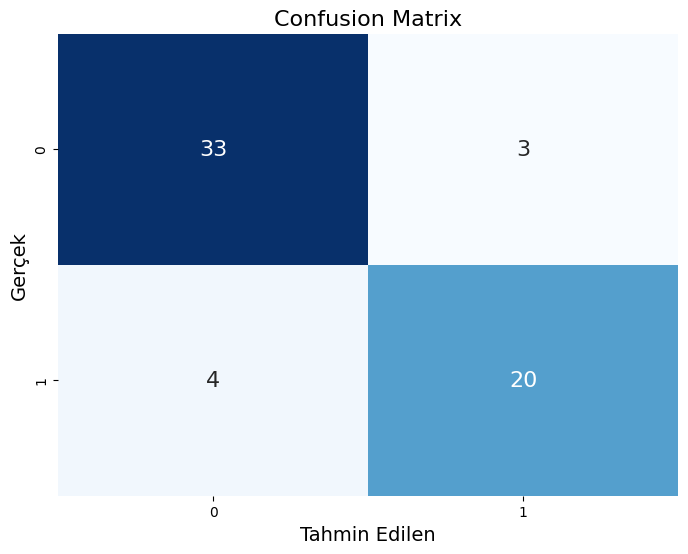

In [118]:
# Logistic Regression modelini oluşturalım
model = LogisticRegression(random_state=42)

# Modeli eğitelim
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapalım
y_pred = model.predict(X_test)

# Modelin performansını değerlendirelim
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk Oranı: {accuracy:.2f}")

# Rapor görüntüleyelim
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix

# Confusion Matrixini oluşturalım
cm = confusion_matrix(y_test, y_pred)

# Görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Tahmin Edilen', fontsize=14)
plt.ylabel('Gerçek', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Doğruluk oranı: 0.92

Karmaşıklık Matrisi:
[[34  2]
 [ 3 21]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.91      0.88      0.89        24

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



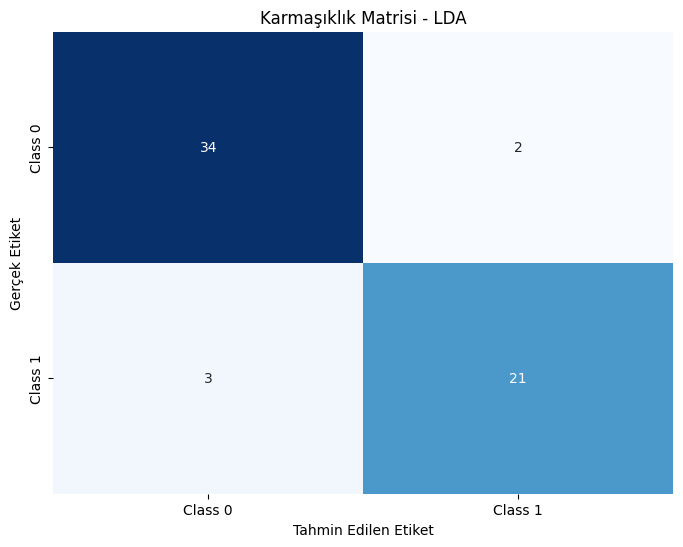

In [119]:
# Linear Discriminant Analysis modelini oluşturalım
lda = LinearDiscriminantAnalysis()

# Modeli eğitim verileri ile eğitelim
lda.fit(X_train, y_train)

# Test verileri üzerinde tahminler yapalım
y_pred = lda.predict(X_test)

# Doğruluk oranını hesaplayalım
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk oranı: {accuracy:.2f}")

# Confusion Matrixi görelim
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nKarmaşıklık Matrisi:")
print(conf_matrix)

# Sınıflandırma raporuna bakalım
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrixini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karmaşıklık Matrisi - LDA')
plt.show()

Doğruluk oranı: 0.88

Karmaşıklık Matrisi:
[[32  4]
 [ 3 21]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



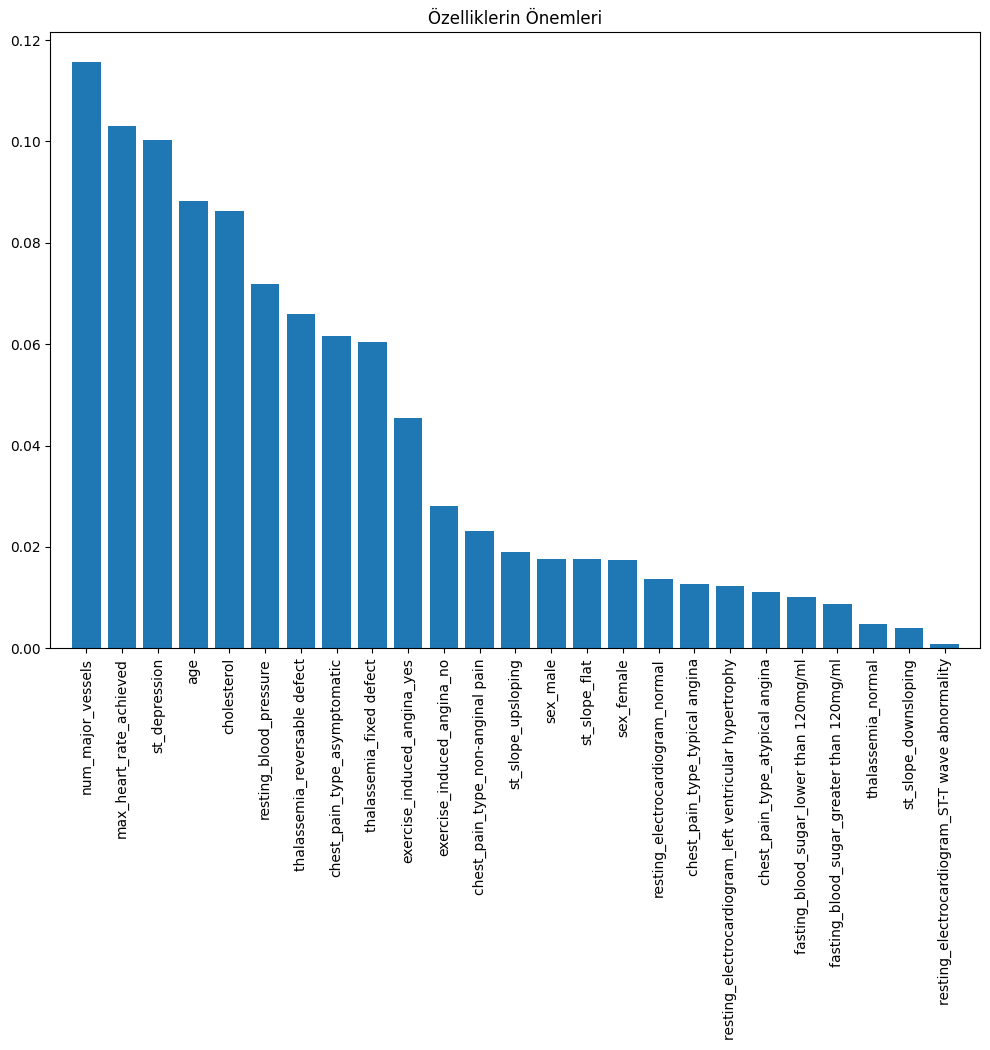

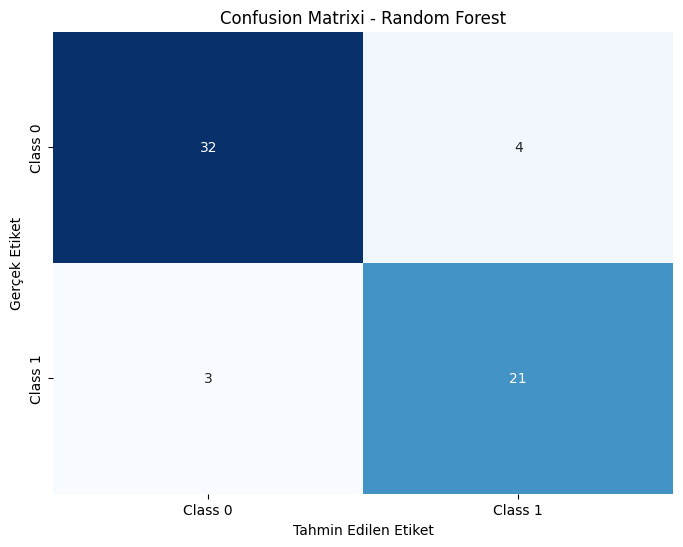

In [120]:
# Random Forest modelini oluşturalım
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Modeli eğitim verileri ile eğitelim
rf_model.fit(X_train, y_train)

# Test verileri üzerinde tahminler yapalım
y_pred = rf_model.predict(X_test)

# Doğruluk oranını hesaplayalım
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk oranı: {accuracy:.2f}")

# Confusion Matrixi oluşturalım 
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nKarmaşıklık Matrisi:")
print(conf_matrix)

# Sınıflandırma raporlayalım
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Özelliklerin önemlerini görselleştirelim
importances = rf_model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.title('Özelliklerin Önemleri')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


# Karmaşıklık matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrixi - Random Forest')
plt.show()

Doğruluk oranı: 0.82

Confusion Matrixi:
[[28  8]
 [ 3 21]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        36
           1       0.72      0.88      0.79        24

    accuracy                           0.82        60
   macro avg       0.81      0.83      0.81        60
weighted avg       0.83      0.82      0.82        60



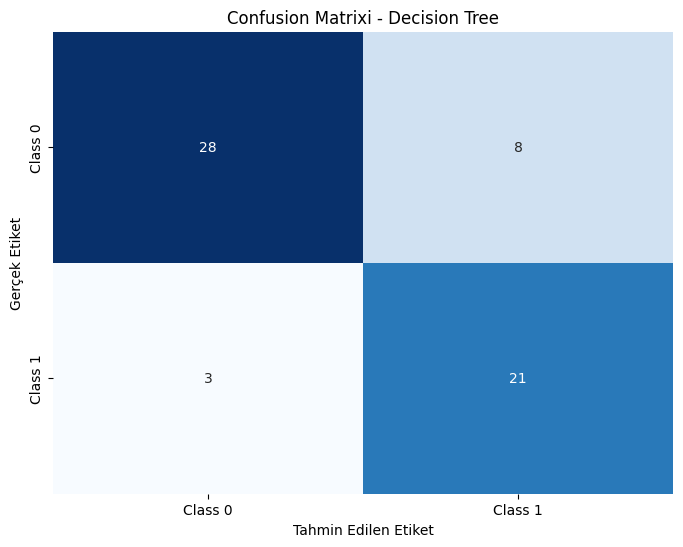

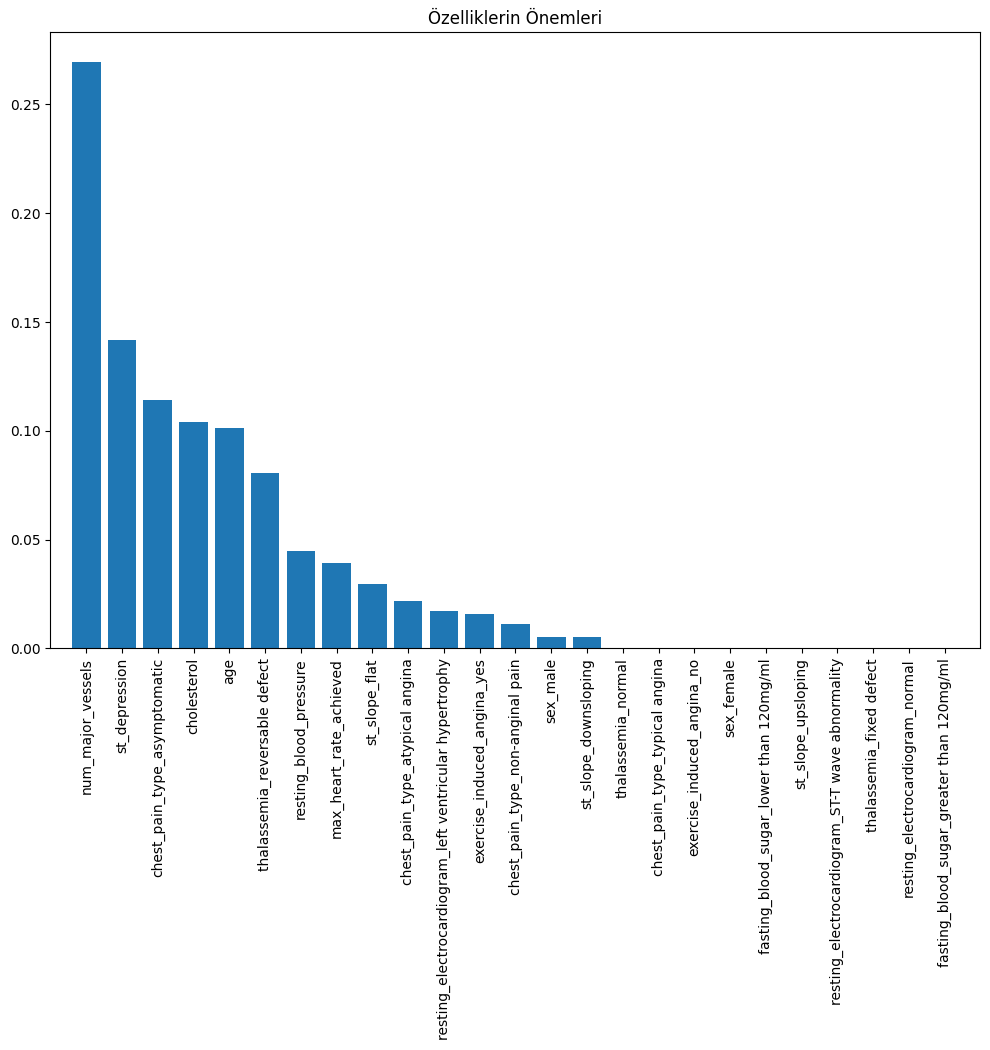

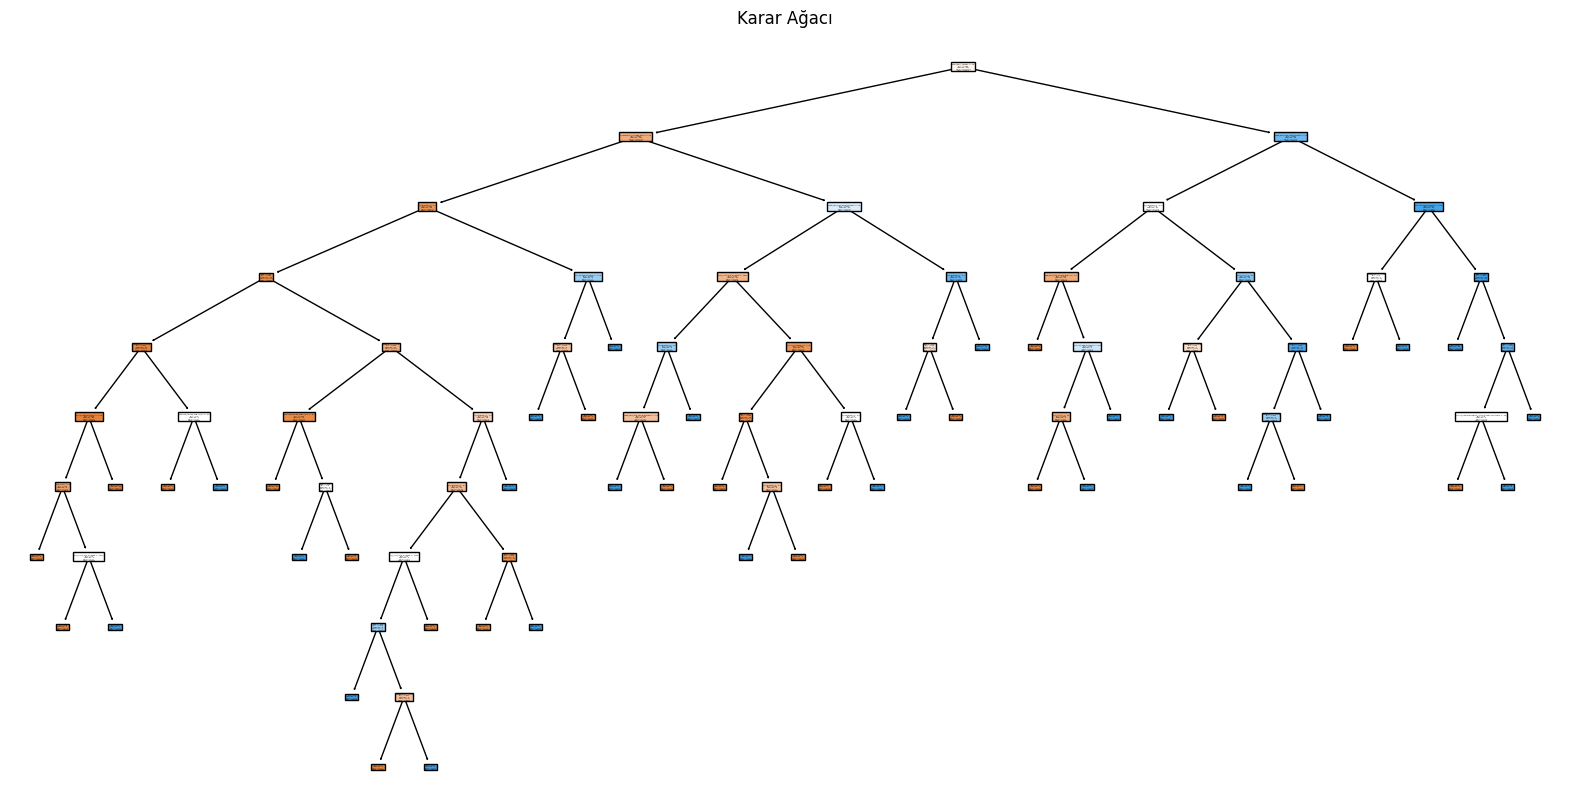

In [121]:
# Decision Tree modelini oluşturalım
dt_model = DecisionTreeClassifier(random_state=42)

# Modeli eğitim verileri ile eğitelim
dt_model.fit(X_train, y_train)

# Test verileri üzerinde tahminler yapalım
y_pred = dt_model.predict(X_test)

# Doğruluk oranını hesaplayalım
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk oranı: {accuracy:.2f}")

# Confusion Matrixini oluşturalım
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrixi:")
print(conf_matrix)

# Sınıflandırma raporlayalım
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Karmaşıklık matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrixi - Decision Tree')
plt.show()


# Özelliklerin önemlerini görselleştirelim
importances = dt_model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.title('Özelliklerin Önemleri')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Karar ağacını görselleştirelim
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.title('Karar Ağacı')
plt.show()


Doğruluk oranı: 0.85

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60


Confusion Matrixi:
[[33  3]
 [ 6 18]]


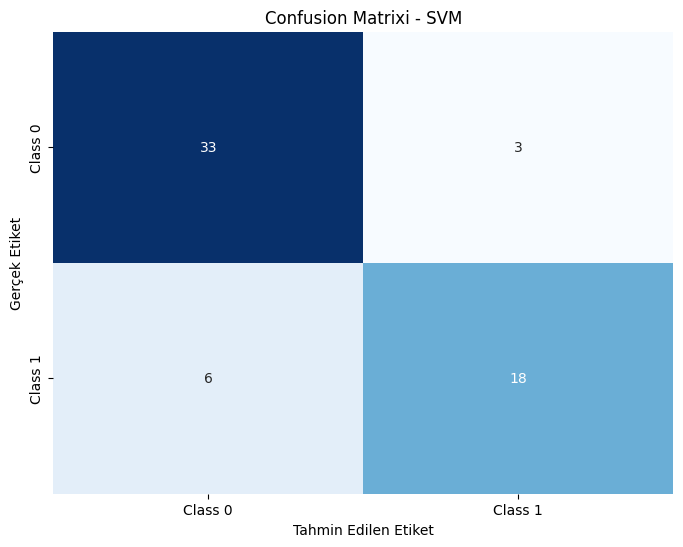

In [122]:
# SVM modelini oluşturalım (C ve kernel parametreleri, modelin hiperparametreleridir)
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Modeli eğitim verileri ile eğitelim
svm_model.fit(X_train, y_train)

# Test verileri üzerinde tahminler yapalım
y_pred = svm_model.predict(X_test)

# Doğruluk oranını hesaplayalım
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk oranı: {accuracy:.2f}")

# Sınıflandırma raporlandıralım
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrixi yapalım
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrixi:")
print(conf_matrix)

# Karmaşıklık matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrixi - SVM')
plt.show()



## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>BİRİNCİ VE İKİNCİ DENEME</span></b> </div>


Logistic Regression Sonuçları:
Doğruluk: 0.88
Confusion Matrixi:
[[33  3]
 [ 4 20]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60


Random Forest Sonuçları:
Doğruluk: 0.92
Confusion Matrixi:
[[33  3]
 [ 2 22]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60


Decision Tree Sonuçları:
Doğruluk: 0.82
Confusion Matrixi:
[[28  8]
 [ 3 21]]
Sınıflandırma Raporu:
              precision    recall  f1

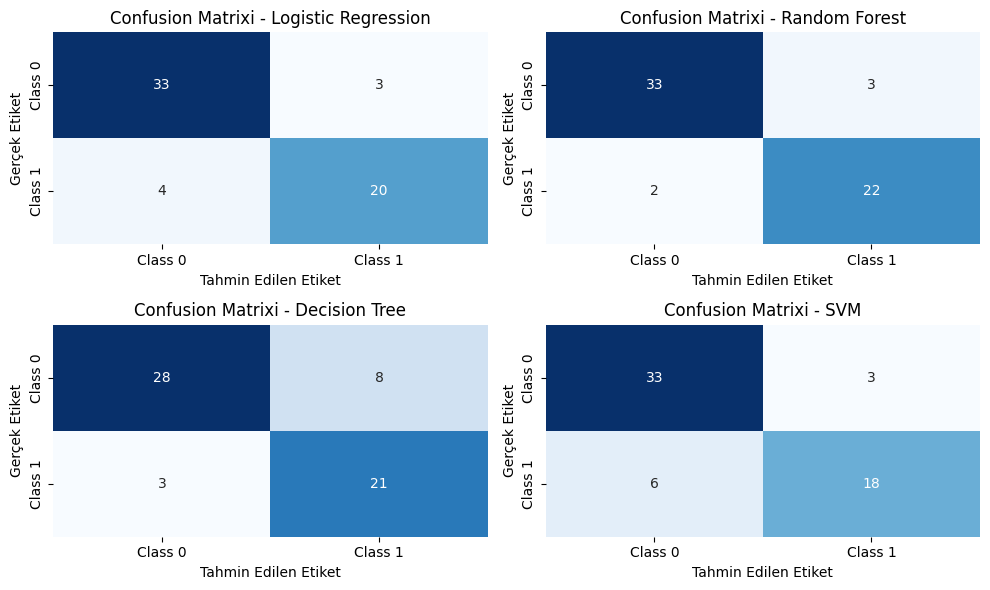

In [123]:
# Tüm modellerin aynı anda sonuçlarını görmek için birleştirelim; 

# Model tanımlamalarını yapalım
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=1.0, random_state=42)
}

# Performans sonuçlarını görelim
results = {}

# Her model için eğitim ve test işlemleri yapalım
for model_name, model in models.items():
    # Modeli eğitim verileri ile eğit
    model.fit(X_train, y_train)
    
    # Test verileri üzerinde tahminler yapalım
    y_pred = model.predict(X_test)
    
    # Performans metriklerini hesaplayalım
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Sonuçları saklayalım
    results[model_name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

# Performans sonuçlarını yazdıralım
for model_name, metrics in results.items():
    print(f"\n{model_name} Sonuçları:")
    print(f"Doğruluk: {metrics['Accuracy']:.2f}")
    print("Confusion Matrixi:")
    print(metrics['Confusion Matrix'])
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, model.predict(X_test)))

# Karmaşıklık matrislerini görselleştirelim
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for i, (model_name, metrics) in enumerate(results.items()):
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrixi - {model_name}')
    axes[i].set_xlabel('Tahmin Edilen Etiket')
    axes[i].set_ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'> ÜÇÜNCÜ DENEME</span></b> </div>

Yeni özellikler ekleyerek modeli güçlendirebilir miyim diye bakıyorum.

In [124]:
#Yaş grupları tanımlamak için Datanın discribeına bakalım. 
df[num_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
max_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
st_depression,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
num_major_vessels,297.0,0.676768,0.938965,0.0,0.0,0.0,1.0,3.0


In [125]:
# Yaş gruplarını tanımlayalım
bins = [0, 30, 40, 50, 60, 70, 80]
labels = ['0-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# 'age' sütununu gruplara ayırarak yeni bir sütun oluşturalım
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Yaş gruplarına ve cinsiyete göre gruplama yaparak toplam, hastalıklı, sağlıklı sayıları ve oranları hesaplayalım
age_sex_group_counts = df.groupby(['age_group', 'sex']).agg(
    total_count=('age', 'size'),                                  # Toplam kişi sayısı
    diseased_count=('target', lambda x: (x == 1).sum()),          # Hastalıklı (target=1) kişi sayısı
    healthy_count=('target', lambda x: (x == 0).sum()),           # Sağlıklı (target=0) kişi sayısı
).reset_index()

# Hastalıklı kişilerin oranını (% olarak) hesaplayalım
age_sex_group_counts['disease_ratio'] = (age_sex_group_counts['diseased_count'] / age_sex_group_counts['total_count']) * 100

# Sonuçları görelim
age_sex_group_counts

,age_group,sex,total_count,diseased_count,healthy_count,disease_ratio
0,0-30,female,0,NaN,NaN,NaN
1,0-30,male,1,0.0,1.0,0.000000
2,31-40,female,5,0.0,5.0,0.000000
3,31-40,male,8,4.0,4.0,50.000000
4,41-50,female,19,1.0,18.0,5.263158
5,41-50,male,52,20.0,32.0,38.461538
6,51-60,female,33,10.0,23.0,30.303030
7,51-60,male,88,49.0,39.0,55.681818
8,61-70,female,34,14.0,20.0,41.176471
9,61-70,male,47,35.0,12.0,74.468085


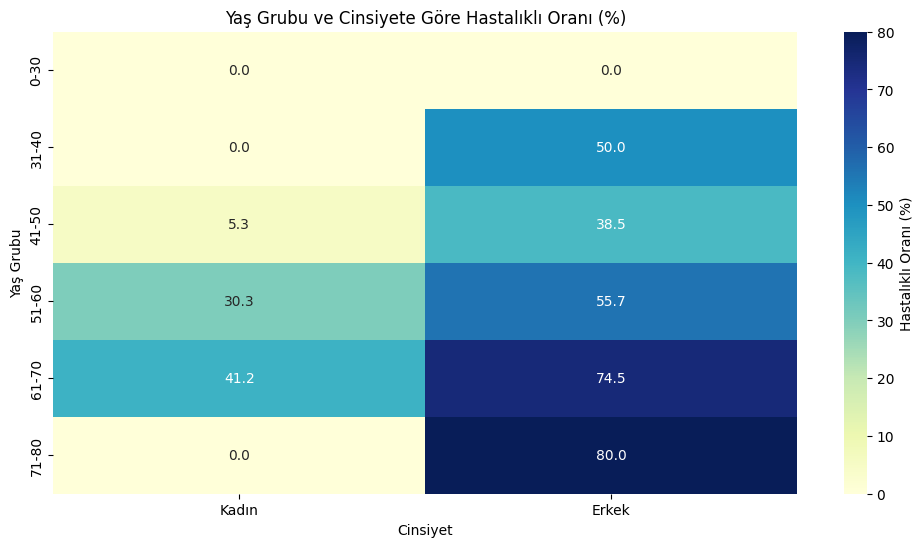

In [126]:
# Pivot tablo oluşturalım (age_group ve sex'e göre)
heatmap_data = age_sex_group_counts.pivot_table(
    values='disease_ratio', index='age_group', columns='sex', fill_value=0
)

# Isı haritası oluşturalım
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Hastalıklı Oranı (%)'})
plt.title('Yaş Grubu ve Cinsiyete Göre Hastalıklı Oranı (%)')
plt.ylabel('Yaş Grubu')
plt.xlabel('Cinsiyet')
plt.xticks([0.5, 1.5], ['Kadın', 'Erkek'], rotation=0)  # Cinsiyet etiketlerini düzgün gösterelim
plt.show()


kendi yaş grubum için 18 sağlıklı 1 hasta gözlemiyle karşılaştım ( 41-50 )... %5,56 'lık bir orana sahip olduğunu öğrenip rahatlıyorum :) 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Yorumlar:</span></b> </div>

en çok gözlemin 88 gözlemle 51-60 yaş grubu erkelere dair olduğu, 

In [127]:
# 'resting_blood_pressure' ve 'max_heart_rate_achieved' sütunları arasında bir oran oluşturalım
df['blood_pressure_to_heart_rate'] = df['resting_blood_pressure'] / df['max_heart_rate_achieved']

# Sonuçları görelim
df[['resting_blood_pressure', 'max_heart_rate_achieved', 'blood_pressure_to_heart_rate']].head()


,resting_blood_pressure,max_heart_rate_achieved,blood_pressure_to_heart_rate
0,145,150,0.966667
1,160,108,1.481481
2,120,129,0.930233
3,130,187,0.695187
4,130,172,0.755814



Logistic Regression Sonuçları:
Doğruluk: 0.88
Confusion Matrixi:
[[33  3]
 [ 4 20]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60


Random Forest Sonuçları:
Doğruluk: 0.92
Confusion Matrixi:
[[33  3]
 [ 2 22]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        36
           1       0.86      0.75      0.80        24

    accuracy                           0.85        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.85      0.85      0.85        60


Decision Tree Sonuçları:
Doğruluk: 0.82
Confusion Matrixi:
[[28  8]
 [ 3 21]]
Sınıflandırma Raporu:
              precision    recall  f1

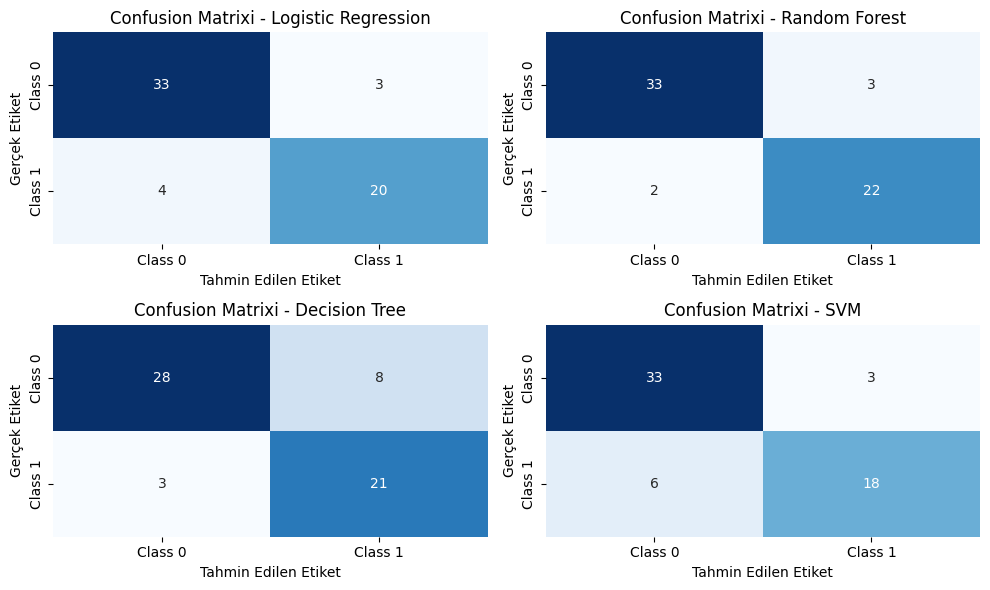

In [128]:
#Yeni özellikler eklendikten sonra makine modellerine göz atalım

# Model tanımlamaları
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=1.0, random_state=42)
}

# Performans sonuçlarını görelim
results = {}

# Her model için eğitim ve test işlemlerini yapalım
for model_name, model in models.items():
    # Modeli eğitim verileri ile eğit
    model.fit(X_train, y_train)
    
    # Test verileri üzerinde tahminler yapalım
    y_pred = model.predict(X_test)
    
    # Performans metriklerini hesaplayalım
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

# Performans sonuçlarını yazdıralım
for model_name, metrics in results.items():
    print(f"\n{model_name} Sonuçları:")
    print(f"Doğruluk: {metrics['Accuracy']:.2f}")
    print("Confusion Matrixi:")
    print(metrics['Confusion Matrix'])
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, model.predict(X_test)))

# Karmaşıklık matrislerini görselleştir
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for i, (model_name, metrics) in enumerate(results.items()):
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrixi - {model_name}')
    axes[i].set_xlabel('Tahmin Edilen Etiket')
    axes[i].set_ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/579216/pexels-photo-579216.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>DÖRDÜNCÜ DENEME </span></b> </div>

Özellikleri çıkararak modeli güçlendirebilir miyim diye bakıyorum.

In [129]:
# Modelleme öncesi hazırlanmış olan veriyi alalım.
df_encoded.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_female,sex_male,chest_pain_type_asymptomatic,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_greater than 120mg/ml,fasting_blood_sugar_lower than 120mg/ml,resting_electrocardiogram_ST-T wave abnormality,resting_electrocardiogram_left ventricular hypertrophy,resting_electrocardiogram_normal,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_downsloping,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0.0,0,False,True,False,False,False,True,True,False,False,True,False,True,False,True,False,False,False,True,False
1,67,160,286,108,1.5,3.0,1,False,True,True,False,False,False,False,True,False,True,False,False,True,False,True,False,True,False,False
2,67,120,229,129,2.6,2.0,1,False,True,True,False,False,False,False,True,False,True,False,False,True,False,True,False,False,False,True
3,37,130,250,187,3.5,0.0,0,False,True,False,False,True,False,False,True,False,False,True,True,False,True,False,False,True,False,False
4,41,130,204,172,1.4,0.0,0,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False


In [130]:
df_encoded.columns

Index(['age', 'resting_blood_pressure', 'cholesterol',
       'max_heart_rate_achieved', 'st_depression', 'num_major_vessels',
       'target', 'sex_female', 'sex_male', 'chest_pain_type_asymptomatic',
       'chest_pain_type_atypical angina', 'chest_pain_type_non-anginal pain',
       'chest_pain_type_typical angina',
       'fasting_blood_sugar_greater than 120mg/ml',
       'fasting_blood_sugar_lower than 120mg/ml',
       'resting_electrocardiogram_ST-T wave abnormality',
       'resting_electrocardiogram_left ventricular hypertrophy',
       'resting_electrocardiogram_normal', 'exercise_induced_angina_no',
       'exercise_induced_angina_yes', 'st_slope_downsloping', 'st_slope_flat',
       'st_slope_upsloping', 'thalassemia_fixed defect', 'thalassemia_normal',
       'thalassemia_reversable defect'],
      dtype='object')

In [131]:
# Her sütunun varyansını hesaplayalım
variances = df_encoded.var()

# Varyansları görüntüleyelim
print(variances)

# Düşük varyanslı özellikleri belirleyelim (varyansı 0.5'den küçük olanlar)
low_variance_features = variances[variances < 0.5 ].index.tolist()

print("Düşük varyanslı özellikler:")
print(low_variance_features)


age                                                         81.897716
resting_blood_pressure                                     315.517290
cholesterol                                               2703.748589
max_heart_rate_achieved                                    526.315270
st_depression                                                1.359842
num_major_vessels                                            0.881654
target                                                       0.249340
sex_female                                                   0.219492
sex_male                                                     0.219492
chest_pain_type_asymptomatic                                 0.250364
chest_pain_type_atypical angina                              0.138229
chest_pain_type_non-anginal pain                             0.202043
chest_pain_type_typical angina                               0.071685
fasting_blood_sugar_greater than 120mg/ml                    0.124238
fasting_blood_sugar_

In [132]:
# Kaldırılacak sütunları seçelim
columns_to_drop = ['sex_female', 
                   'sex_male', 
                   'chest_pain_type_asymptomatic', 
                   'chest_pain_type_atypical angina', 
                   'chest_pain_type_non-anginal pain', 
                   'chest_pain_type_typical angina', 
                   'fasting_blood_sugar_greater than 120mg/ml', 
                   'fasting_blood_sugar_lower than 120mg/ml', 
                   'resting_electrocardiogram_ST-T wave abnormality', 
                   'resting_electrocardiogram_left ventricular hypertrophy',
                   'resting_electrocardiogram_normal', 'exercise_induced_angina_no', 
                   'exercise_induced_angina_yes', 'st_slope_downsloping', 'st_slope_flat', 
                   'st_slope_upsloping', 'thalassemia_fixed defect', 'thalassemia_normal',
                   'thalassemia_reversable defect']

# Sütunları veri setinden çıkartalım
ddeneme = df_encoded.drop(columns=columns_to_drop, errors='ignore')

# Sonuçları görelim
ddeneme.head()


,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
0,63,145,233,150,2.3,0.0,0
1,67,160,286,108,1.5,3.0,1
2,67,120,229,129,2.6,2.0,1
3,37,130,250,187,3.5,0.0,0
4,41,130,204,172,1.4,0.0,0


In [133]:
# Özellikler (X) ve hedef değişkeni (y) ayıralım
X = ddeneme.drop(columns=['target']) 
y = ddeneme['target'] 

# X ve y'nin boyutlarını kontrol edelim
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (297, 6)
y shape: (297,)


In [134]:
# Veri setini eğitim ve test olarak ikiye ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ) #otostopçunun galaksi rehberine selam. :)

# Bölme işlemi sonrası veri boyutlarını kontrol edelim
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (237, 6)
X_test shape: (60, 6)
y_train shape: (237,)
y_test shape: (60,)



Logistic Regression Sonuçları:
Doğruluk: 0.78
Confusion Matrisi:
[[31  5]
 [ 8 16]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        36
           1       0.71      0.71      0.71        24

    accuracy                           0.77        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60


Random Forest Sonuçları:
Doğruluk: 0.68
Confusion Matrisi:
[[25 11]
 [ 8 16]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        36
           1       0.71      0.71      0.71        24

    accuracy                           0.77        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60


Decision Tree Sonuçları:
Doğruluk: 0.65
Confusion Matrisi:
[[22 14]
 [ 7 17]]
Sınıflandırma Raporu:
              precision    recall  f1

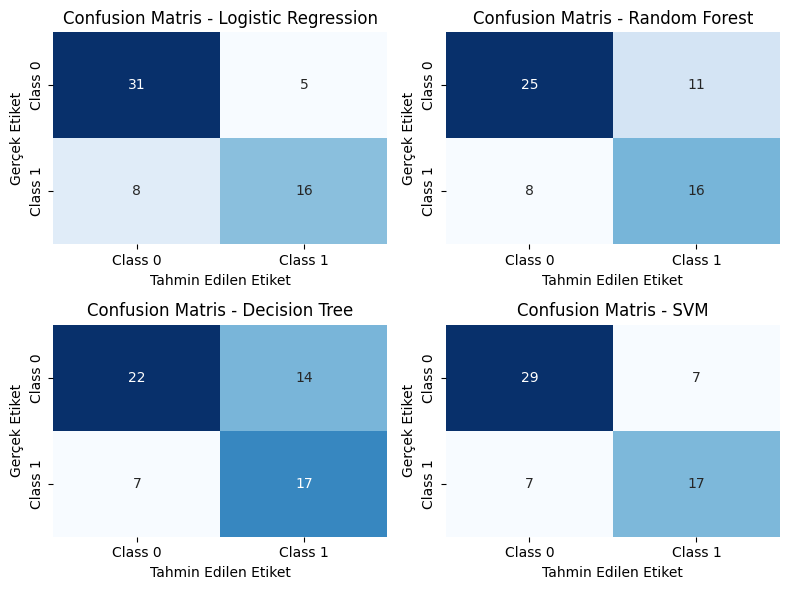

In [135]:
## Özellikler çıkarıldıktan sonra makine modellerine göz atalım


# Model tanımlamalarına bakalım
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=1.0, random_state=42)
}

# Performans sonuçlarını görelim
results = {}

# Her model için eğitim ve test işlemlerini yapalım
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

# Performans sonuçlarını yazdıralım
for model_name, metrics in results.items():
    print(f"\n{model_name} Sonuçları:")
    print(f"Doğruluk: {metrics['Accuracy']:.2f}")
    print("Confusion Matrisi:")
    print(metrics['Confusion Matrix'])
    print("Sınıflandırma Raporu:")
    print(classification_report(y_test, model.predict(X_test)))

# Karmaşıklık matrislerini görelim
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for i, (model_name, metrics) in enumerate(results.items()):
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matris - {model_name}')
    axes[i].set_xlabel('Tahmin Edilen Etiket')
    axes[i].set_ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()
